<a href="https://colab.research.google.com/github/fressbish/Koptev-Dmitry/blob/main/task3_gnn_KoptevDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Коптев Д.А., GNN, Задание 3

## Задача 3. Graph Convolutional Network

 - Найти графовый набор данных для решения задачи предсказания (классификация вершин, обнаружение сообществ и т.д.).
 - Использовать несколько слоев GCNConv из библиотеки PyG для построения GCN модели.
 - Обучить полученную модель, подобрать гиперпараметры (например, learning rate) на валидационной выборке, и оценить качество предсказания на тестовой выборке.
 - (+5 баллов) Также представить самостоятельную реализацию слоя GCNConv, используя матричные операции. Повторить обучение с собственными слоями и сравнить результаты.

In [29]:
# !pip install torch-scatter
# !pip install torch_geometric

In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm.auto import trange

from torch import Tensor
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from itertools import product

import warnings
warnings.filterwarnings("ignore")

### **Датасет**

In [31]:
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

In [5]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [6]:
data.num_nodes, data.num_edges

(2708, 10556)

In [7]:
class GraphModel(torch.nn.Module):
    def __init__(self, features, emb_size, classes, conv_layer=GCNConv):
        super().__init__()
        torch.manual_seed(123)
        self.layer1 = conv_layer(features, emb_size * 2)
        self.layer2 = conv_layer(emb_size * 2, emb_size)
        self.layer3 = conv_layer(emb_size, classes)

    def forward(self, features, edges):
        x = self.layer1(features, edges).relu()
        x = self.layer2(x, edges).relu()
        x = self.layer3(x, edges)
        return x

In [8]:
# функция для обучения модели
def train_epoch(graph_data, gnn, optim, loss_fn):
    gnn.train()
    optim.zero_grad()
    predictions = gnn(graph_data.x, graph_data.edge_index)
    loss = loss_fn(predictions[graph_data.train_mask], graph_data.y[graph_data.train_mask])
    loss.backward()
    optim.step()
    return loss

In [9]:
# проверка на валидации
def evaluate(graph_data, gnn, mask_key):
    gnn.eval()
    with torch.no_grad():
        logits = gnn(graph_data.x, graph_data.edge_index)
        preds = logits.argmax(dim=1)
        correct = preds[graph_data[mask_key]] == graph_data.y[graph_data[mask_key]]
        accuracy = int(correct.sum()) / int(graph_data[mask_key].sum())
    return accuracy

In [10]:
# гиперпараметры
emb_sizes = [8, 16, 32]
learning_rates = [0.1, 0.05, 0.01]
epochs = 30

results_summary = {}

for emb_size, lr in product(emb_sizes, learning_rates):
    gnn_model = GraphModel(dataset.num_features, emb_size, dataset.num_classes)
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=lr, weight_decay=5e-4)
    loss_func = CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss = train_epoch(data, gnn_model, optimizer, loss_func)

    val_accuracy = evaluate(data, gnn_model, 'val_mask')
    test_accuracy = evaluate(data, gnn_model, 'test_mask')

    config = f"emb_size={emb_size}, lr={lr}"
    results_summary[config] = {"val_acc": val_accuracy, "test_acc": test_accuracy, "final_loss": train_loss.item()}
    print(f"Config: {config} | Val Accuracy: {val_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}")

# вывод лучшего результата
best_config = max(results_summary, key=lambda cfg: results_summary[cfg]["val_acc"])
print(f"\nBest config: {best_config}")
print(f"Results: {results_summary[best_config]}")

Config: emb_size=8, lr=0.1 | Val Accuracy: 0.6740 | Test Accuracy: 0.6900
Config: emb_size=8, lr=0.05 | Val Accuracy: 0.6300 | Test Accuracy: 0.6450
Config: emb_size=8, lr=0.01 | Val Accuracy: 0.5060 | Test Accuracy: 0.5380
Config: emb_size=16, lr=0.1 | Val Accuracy: 0.7360 | Test Accuracy: 0.7430
Config: emb_size=16, lr=0.05 | Val Accuracy: 0.7200 | Test Accuracy: 0.7280
Config: emb_size=16, lr=0.01 | Val Accuracy: 0.6120 | Test Accuracy: 0.6370
Config: emb_size=32, lr=0.1 | Val Accuracy: 0.3900 | Test Accuracy: 0.4290
Config: emb_size=32, lr=0.05 | Val Accuracy: 0.7920 | Test Accuracy: 0.8000
Config: emb_size=32, lr=0.01 | Val Accuracy: 0.7720 | Test Accuracy: 0.7700

Best config: emb_size=32, lr=0.05
Results: {'val_acc': 0.792, 'test_acc': 0.8, 'final_loss': 0.06059688702225685}


Training:   0%|          | 0/100 [00:00<?, ?it/s]

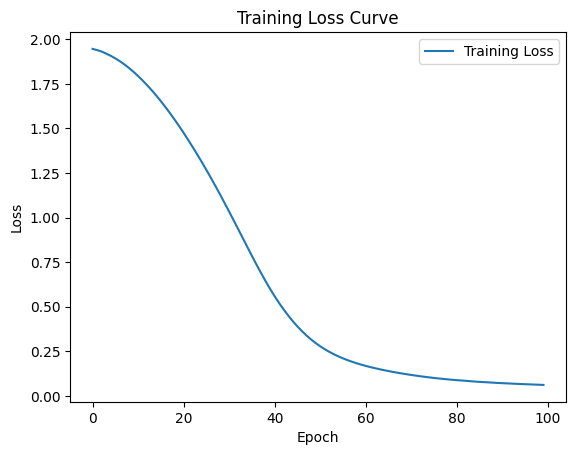

In [11]:
# финальное обучение и визуализация
lr = 0.01
emb_size = 16
epochs = 100

final_model = GraphModel(dataset.num_features, emb_size, dataset.num_classes)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=lr, weight_decay=5e-4)

all_losses = []
for epoch in trange(epochs, desc="Training"):
    epoch_loss = train_epoch(data, final_model, final_optimizer, loss_func)
    all_losses.append(epoch_loss.item())

plt.plot(all_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curve')
plt.show()

In [28]:
evaluate(data, final_model, 'val_mask'), evaluate(data, final_model, 'test_mask')

(0.778, 0.789)

### **Визуализация**

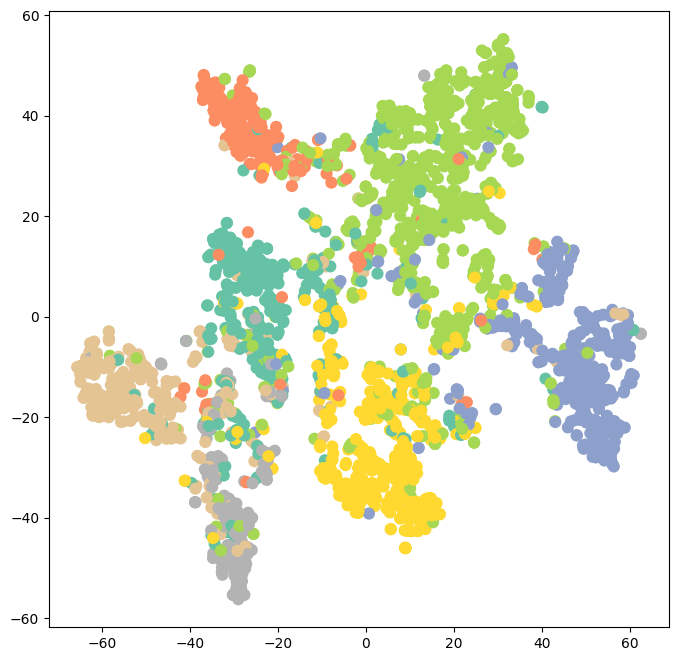

In [13]:
final_model.eval()
embeddings = final_model(data.x, data.edge_index)

embeddings_2d = TSNE(n_components=2).fit_transform(embeddings.detach().cpu().numpy())
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=data.y.cpu(), cmap="Set2", s=60)
plt.show()

модель в целом выделяет кластеры, но узлы на границах часто классифицируются неверно, поэтому кластеры перемешиваются

In [14]:
import torch
from torch import nn
import math

class CustomGCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_dim, out_dim))
        self.bias = nn.Parameter(torch.FloatTensor(out_dim))
        self.reset_params()

    def reset_params(self):
        # веса и смещения
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def add_self_loops(self, edge_index, num_nodes):
        # self-loops
        loop_edges = torch.arange(0, num_nodes, dtype=torch.long, device=edge_index.device)
        return torch.cat([edge_index, loop_edges.unsqueeze(0).repeat(2, 1)], dim=1)

    def normalize_adjacency(self, edge_index, num_nodes):
        # нормализация
        row, col = edge_index
        degree = torch.bincount(row, minlength=num_nodes)
        deg_inv_sqrt = degree.float().pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0  # защита от деления на 0
        norm_weights = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return edge_index, norm_weights

    def forward(self, features, edge_index):
        num_nodes = features.size(0)
        # self-loops + нормализация
        edge_index = self.add_self_loops(edge_index, num_nodes)
        edge_index, edge_weight = self.normalize_adjacency(edge_index, num_nodes)

        # A_hat @ X @ W + b
        support = torch.mm(features, self.weight)
        row, col = edge_index
        output = torch.zeros_like(support)
        output.index_add_(0, row, support[col] * edge_weight.unsqueeze(1))
        return output + self.bias

In [15]:
# обучение модели
learning_rate = 0.01
emb_size = 16
epochs_to_train = 100

custom_model = GraphModel(
    features=dataset.num_features,
    emb_size=emb_size,
    classes=dataset.num_classes,
    conv_layer=CustomGCNLayer,
)

custom_optimizer = torch.optim.Adam(custom_model.parameters(), lr=learning_rate, weight_decay=5e-4)
loss_function = nn.CrossEntropyLoss()

In [16]:
custom_losses = []
training_bar = trange(epochs_to_train, desc="Training (Custom GCN)")
for epoch in training_bar:
    train_loss = train_epoch(data, custom_model, custom_optimizer, loss_function)
    custom_losses.append(train_loss.item())
    training_bar.set_description(f"Epoch {epoch+1:03d} | Loss: {train_loss:.4f}")

Training (Custom GCN):   0%|          | 0/100 [00:00<?, ?it/s]

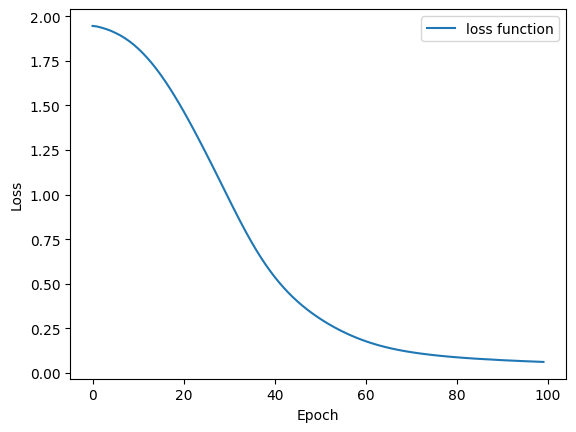

In [23]:
# график изменения loss
plt.plot(custom_losses, label='loss function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
# результаты валидации и теста
evaluate(data, custom_model, 'val_mask'), evaluate(data, custom_model, 'test_mask')

(0.802, 0.789)

Точность на валидационных данных повысилась, а на тестовых не изменилась